In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Importing Libraries

import numpy as np # for linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import KFold,train_test_split,cross_validate, ShuffleSplit
import tensorflow_addons as tfa
from keras import backend as K
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
import torch as torch
import transformers as ppb
import spacy


### **Outline** ###

1. Preprocessing Text
2. Transfer Learning From the Pretrained BERT Model
3. Recurrent Network with the Long Short-Term Memory Cells
4. Classifier for Keywords
5. Ensembler Learner
6. Predicting Test Data

In [3]:
# Importing Dataset
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train.target.sum() / df_train.target.count()

0.4296597924602653

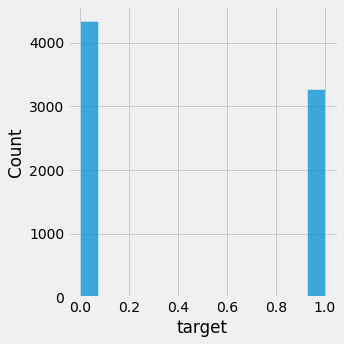

In [6]:
plt.style.use('fivethirtyeight')
sns.displot(data=df_train, x="target")

### **Clean Keyword** ###

In [7]:
def format_keyword(df):
    df["keyword"] = df["keyword"].fillna(".")
    df["keyword"] = df.keyword.str.replace("%20"," ")

In [8]:
format_keyword(df_train)

In [9]:
df_train.loc[df_train.target==0]["keyword"].value_counts()

body bags          40
harm               37
armageddon         37
wrecked            36
deluge             36
                   ..
typhoon             1
suicide bomber      1
outbreak            1
oil spill           1
suicide bombing     1
Name: keyword, Length: 219, dtype: int64

In [10]:
format_keyword(df_test)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3263 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### **Clean Text** ###

In [12]:
df_count = df_train.text.str.split().str.len()
max(df_count)

31

In [13]:
import re
def process_text(text):
    text=text.replace("\n","")
    text = re.sub(r'@\S+','',text)
    text = re.sub(r'#\S+','',text) 
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+','',text) 
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    text = text.lower()
    text = text.split()
    res = ""
    for token in text:
        if not token==" ":
            res += token +" "
    
    return res

In [14]:
sample_doc = "!!! @user @twi #topic \n\nHello,   UTC20150805 World http://t.com"
process_text(sample_doc)

'hello utc world '

In [15]:
df_train["text"] = df_train.text.transform(lambda x: process_text(x))
df_test["text"] = df_test.text.transform(lambda x: process_text(x))

### **Duplicate Tweet With Ambiguous Target** ###

In [16]:
df_train["appears"]=df_train.groupby("text").text.transform("count")

In [17]:
df_train["target_std"]=df_train.groupby("text").target.transform(np.std)
df_train["target_mean"]=df_train.groupby("text").target.transform(np.mean)

In [18]:
duplicate_ids = df_train.loc[df_train.target_std>0].sort_values(by=["appears","text"],ascending=False).index

In [19]:
duplicate_ids

Int64Index([4391, 4392, 4393, 4394, 4396, 4397, 4399, 4400, 4403, 4404,
            ...
            5813, 5814, 4232, 4235, 1164, 1186,  321,  323, 2649, 2675],
           dtype='int64', length=336)

In [20]:
df_train = df_train.drop(index = duplicate_ids)

In [21]:
df_train = df_train.drop_duplicates(subset=["text"])

In [22]:
df_train.reset_index(drop=True,inplace=True)
df_train

,id,keyword,location,text,target,appears,target_std,target_mean
0,1,.,NaN,our deeds are the reason of this may allah for...,1,1,NaN,1.0
1,4,.,NaN,forest fire near la ronge sask canada,1,1,NaN,1.0
2,5,.,NaN,all residents asked to shelter in place are be...,1,1,NaN,1.0
3,6,.,NaN,people receive evacuation orders in california,1,1,NaN,1.0
4,7,.,NaN,just got sent this photo from ruby as smoke fr...,1,1,NaN,1.0
...,...,...,...,...,...,...,...,...
6662,10854,.,NaN,in km ssw of anza california users download th...,1,1,NaN,1.0
6663,10860,.,NaN,a siren just went off and it wasnt the forney ...,1,1,NaN,1.0
6664,10862,.,NaN,officials say a quarantine is in place at an a...,1,1,NaN,1.0
6665,10864,.,NaN,on the flip side im at walmart and there is a ...,1,1,NaN,1.0


In [23]:
nlp = spacy.load("en_core_web_lg")
keyword_train = np.array([nlp(text).vector for text in df_train.keyword])
keyword_test = np.array([nlp(text).vector for text in df_test.keyword])

In [24]:
def nlp_vectors(text):
    res = []
    doc = nlp(text)
    for token in doc:
        if not token.is_space:
            res.append(token.vector)
    return res

def build_nlp_vectors(df_text):
    spacy_vectors = ([nlp_vectors(text) for text in df_text])
    max_length = 0;
    for vector in spacy_vectors:
        max_length = max(max_length, len(vector))
    print(f"Maximum Length:{ max_length}")
    for i in range(len(spacy_vectors)):
        while(len(spacy_vectors[i]) <max_length):
            spacy_vectors[i].append([0]*300)
    spacy_vectors = np.array(spacy_vectors)
    print(f"Shape of spacy vector:{spacy_vectors.shape}")
    return spacy_vectors

In [25]:
nlp_train = build_nlp_vectors(df_train.text)

Maximum Length:32
Shape of spacy vector:(6667, 32, 300)


In [26]:
tokenizer = ppb.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = ppb.DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
def process_data(df_text):
    tokens = df_text.apply(lambda text: tokenizer.encode(text,add_special_tokens=True))
    max_len = 0;
    i = 0;
    for token in tokens.values:
        max_len = max(max_len,len(token))
    print(f"Max Length: {max_len}")
    
    padded = np.array([i+[0]*(max_len-len(i)) for i in tokens.values])
    attention_mask = np.where(padded !=0, 1,0)
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    with torch.no_grad():
        last_hidden_states = bert_model(input_ids,attention_mask=attention_mask)
    X = last_hidden_states[0][:,0,:].numpy()
    print(X.shape)
    return X

In [28]:
X_train = process_data(df_train.text)

Max Length: 43
(6667, 768)


In [29]:
y_train = df_train.target

In [30]:
X_tr, X_val, nlp_tr, nlp_val, kw_tr, kw_val, y_tr, y_val = train_test_split(X_train,nlp_train, keyword_train, y_train, test_size=0.25, train_size=0.75,shuffle=True)

### **Transfer Learning Model** ###

In [31]:
def build_nn():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(768,)))
    model.add(layers.Dense(128,activation='tanh'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(32,activation='tanh'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(8,activation='tanh'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy'])
    return model

### **kFold Cross Validation** ###

In [32]:
fold = 4
def plot_history(history):
    plt.figure(figsize=(4*fold,4*2))
    for i in range(fold):
        plt.subplot(2,fold,i+1)
        plt.plot(history_by_fold[i].history["loss"])
        plt.plot(history_by_fold[i].history["val_loss"])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Train","Validation"])

        plt.subplot(2,fold,fold+i+1)
        plt.plot(history_by_fold[i].history["accuracy"])
        plt.plot(history_by_fold[i].history["val_accuracy"])
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Train","Validation"])

In [33]:
kfold = KFold(n_splits=4, shuffle=True, random_state=1)

In [34]:
def eval_f1_score(X_val, y_val, model):
    pred_val = (model.predict(X_val)>0.5)
    f1 = f1_score(y_val,pred_val)
    return f1

In [35]:
EPOCHS = 100
BATCH_SIZE = 64

-- Fold 0 -- 
loss: 0.4570494592189789
accuracy: 0.8068386316299438
F1 Score: 0.7436305732484076
-- Fold 1 -- 
loss: 0.4456479549407959
accuracy: 0.8074384927749634
F1 Score: 0.7478397486252946
-- Fold 2 -- 
loss: 0.45003044605255127
accuracy: 0.8116376996040344
F1 Score: 0.7515822784810126
-- Fold 3 -- 
loss: 0.4345151484012604
accuracy: 0.8211284279823303
F1 Score: 0.7608346709470305
0.811760812997818 +\- 0.005715717123269271


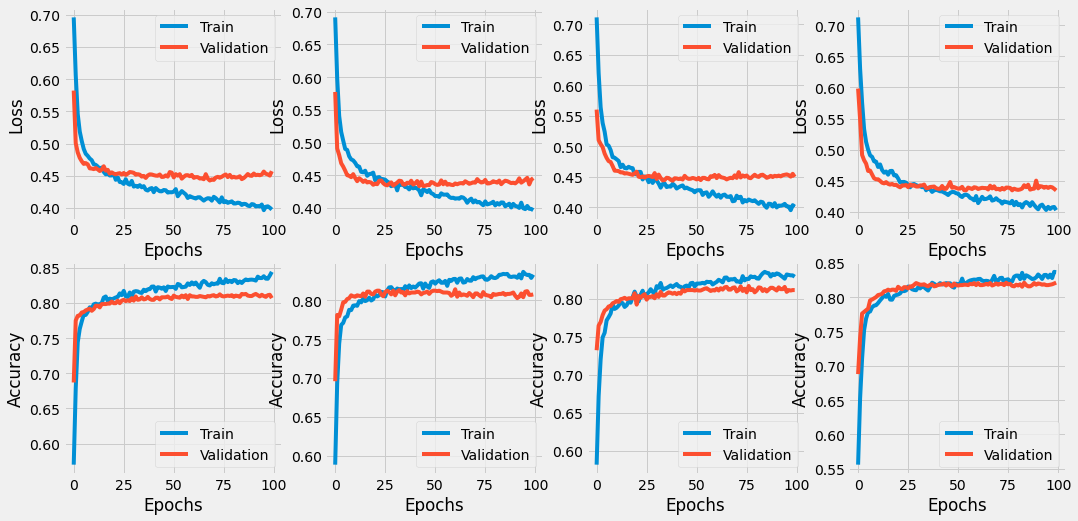

In [36]:
fold = 0
history_by_fold = []
cv_results = []
for train,val in kfold.split(X_train,y_train):
    nn_model = build_nn()
    history = nn_model.fit(X_train[train],y_train[train],
                          validation_data=(X_train[val],y_train[val]),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    scores = nn_model.evaluate(X_train[val],y_train[val],verbose=0)
    print(f"-- Fold {fold} -- ")
    print(f"{nn_model.metrics_names[0]}: {scores[0]}")
    print(f"{nn_model.metrics_names[1]}: {scores[1]}")
    print(f"F1 Score: {eval_f1_score(X_train[val],y_train[val],nn_model)}")

    cv_results.append(scores[1])
    history_by_fold.append(history)
    fold+=1
print(f"{np.mean(cv_results)} +\- {np.std(cv_results)}")
plot_history(history)

### **Training** ###

In [37]:
nn_model = build_nn()
history = nn_model.fit(X_tr,y_tr, validation_data=(X_val,y_val),
                      epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=0)
scores= nn_model.evaluate(X_val,y_val,verbose=0)
print(f"Accuracy: {scores[1]}")
print(f"F1 Score: {eval_f1_score(X_val,y_val,nn_model)}")

Accuracy: 0.809838056564331
F1 Score: 0.7416462917685411


Text(0, 0.5, 'Accuracy')

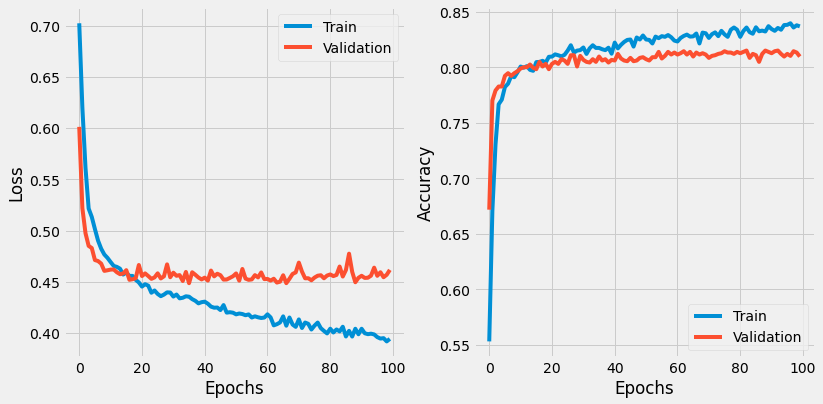

In [38]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### **Recurrent Network with Long Short-Term Memory Cells** ###

In [39]:
def build_LSTM():
    lstm_model = tf.keras.Sequential()
    lstm_model.add(layers.Input(shape=(None,300)))
    lstm_model.add(layers.LSTM(16)) 
    lstm_model.add(layers.Dense(8, activation="tanh"))
    lstm_model.add(layers.Dense(8, activation="tanh"))
    lstm_model.add(layers.Dense(1,activation="sigmoid"))

    lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(5e-5),
                      metrics=['accuracy'])
    return lstm_model


In [40]:
EPOCHS =  30;
BATCH_SIZE = 64;

In [41]:
kfold = KFold(n_splits=4, shuffle=True, random_state=1)

In [42]:
fold = 0
history_by_fold = []
cv_results = []
for train, val in kfold.split(nlp_train,y_train):
    lstm_model = build_LSTM()
    history = lstm_model.fit(nlp_train[train],y_train[train],
                            validation_data=(nlp_train[val],y_train[val]),
                            epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
    scores = lstm_model.evaluate(nlp_train[val],y_train[val],verbose=0)
    
    #df_test[f"Fold{fold}"] = lstm_model.predict(X_test)
    #df_train[f"Fold{fold}"] = lstm_model.predict(X_train)
    print(f"-- Fold{fold} --")
    print(f"{lstm_model.metrics_names[0]}: {scores[0]}")
    print(f"{lstm_model.metrics_names[1]}: {scores[1]}")
    print(f"F1 Score: {eval_f1_score(nlp_train[val],y_train[val],lstm_model)}")

    cv_results.append(scores[1])
    history_by_fold.append(history)
    fold+=1
print(f"{np.mean(cv_results)} +\- {np.std(cv_results)}")

-- Fold0 --
loss: 0.4525057077407837
accuracy: 0.804439127445221
F1 Score: 0.7412698412698413
-- Fold1 --
loss: 0.4653279781341553
accuracy: 0.7990401983261108
F1 Score: 0.7388932190179267
-- Fold2 --
loss: 0.4729437530040741
accuracy: 0.797840416431427
F1 Score: 0.7385570209464701
-- Fold3 --
loss: 0.4617999792098999
accuracy: 0.7995198369026184
F1 Score: 0.7477341389728097
0.8002098947763443 +\- 0.002517201136644893


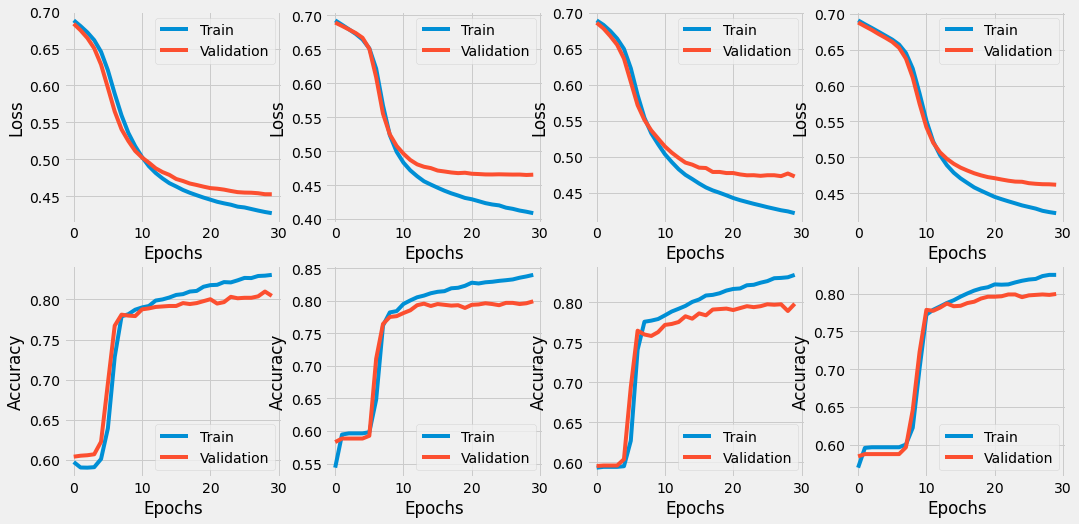

In [43]:
plt.figure(figsize=(4*fold,4*2))
for i in range(fold):
    plt.subplot(2,fold,i+1)
    plt.plot(history_by_fold[i].history["loss"])
    plt.plot(history_by_fold[i].history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Validation"])

    plt.subplot(2,fold,fold+i+1)
    plt.plot(history_by_fold[i].history["accuracy"])
    plt.plot(history_by_fold[i].history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Validation"])

In [44]:
lstm_model = build_LSTM()
history = lstm_model.fit(nlp_tr,y_tr,validation_data=(nlp_val,y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
79/79 [==============================] - 4s 27ms/step - loss: 0.6924 - accuracy: 0.5496 - val_loss: 0.6899 - val_accuracy: 0.5849
Epoch 2/30
79/79 [==============================] - 1s 19ms/step - loss: 0.6890 - accuracy: 0.5873 - val_loss: 0.6862 - val_accuracy: 0.5849
Epoch 3/30
79/79 [==============================] - 1s 18ms/step - loss: 0.6837 - accuracy: 0.5983 - val_loss: 0.6815 - val_accuracy: 0.5849
Epoch 4/30
79/79 [==============================] - 1s 18ms/step - loss: 0.6790 - accuracy: 0.5933 - val_loss: 0.6749 - val_accuracy: 0.5849
Epoch 5/30
79/79 [==============================] - 1s 18ms/step - loss: 0.6689 - accuracy: 0.5980 - val_loss: 0.6651 - val_accuracy: 0.5849
Epoch 6/30
79/79 [==============================] - 1s 19ms/step - loss: 0.6579 - accuracy: 0.5964 - val_loss: 0.6470 - val_accuracy: 0.5981
Epoch 7/30
79/79 [==============================] - 2s 20ms/step - loss: 0.6293 - accuracy: 0.6312 - val_loss: 0.6179 - val_accuracy: 0.6755
Epoch 8/30
79

In [45]:
valid_predict  = (lstm_model.predict(nlp_val) > 0.5)
f1 = f1_score(y_val, valid_predict)
print(f" F1 Score: {f1}")

 F1 Score: 0.7419847328244275


Text(0, 0.5, 'Accuracy')

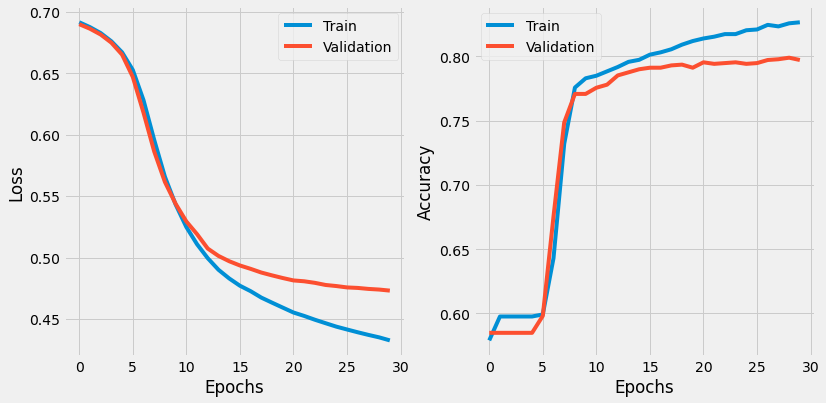

In [46]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train","Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### **Classification With Keywords** ###

In [47]:
lr_keywords = LogisticRegression(max_iter=500)
lr_keywords.fit(kw_tr,y_tr)
val_pred = lr_keywords.predict(kw_val)
print(f"Accurcay: {accuracy_score(y_val, val_pred)}")
print(f"F1 score: {f1_score(y_val,val_pred)}")

Accurcay: 0.713257348530294
F1 score: 0.6351145038167939


### **Ensembler Learning** ###

In [48]:
nn_tr_predict = nn_model.predict(X_tr)
kw_tr_predict = lr_keywords.predict_proba(kw_tr)[:,1]
lstm_tr_predict = lstm_model.predict(nlp_tr)

nn_val_predict = nn_model.predict(X_val)
kw_val_predict = lr_keywords.predict_proba(kw_val)[:,1]
lstm_val_predict = lstm_model.predict(nlp_val)

kw_tr_predict = kw_tr_predict.reshape((kw_tr_predict.shape[0],1))
kw_val_predict = kw_val_predict.reshape((kw_val_predict.shape[0],1))


concat_tr = np.concatenate((nn_tr_predict, kw_tr_predict, lstm_tr_predict), axis=1)
concat_val = np.concatenate((nn_val_predict, kw_val_predict, lstm_val_predict), axis=1)

In [49]:
lr = LogisticRegression()
lr.fit(concat_tr,y_tr)
val_pred = lr.predict(concat_val)
print(f"Accurcay: {accuracy_score(y_val, val_pred)}")
print(f"F1 score: {f1_score(y_val,val_pred)}")

Accurcay: 0.829634073185363
F1 score: 0.7763779527559055


## **Predicting Text** ##

### **Processing Test Data** ###

In [50]:
X_test = process_data(df_test.text)

Max Length: 42
(3263, 768)


In [51]:
nlp_test = build_nlp_vectors(df_test.text)

Maximum Length:33
Shape of spacy vector:(3263, 33, 300)


### **Model Prediction** ###

In [52]:
df_test["nn_predict"]= nn_model.predict(X_test)
df_test["lstm_predict"]= lstm_model.predict(nlp_test)
df_test["keyword_predict"] = lr_keywords.predict_proba(keyword_test)[:,1]
features = ["nn_predict","keyword_predict","lstm_predict"]

test_features = df_test[features]
predict = lr.predict(test_features)

In [53]:
output = pd.DataFrame({"id":df_test.id, "target":predict})
output.to_csv("submission.csv",index=False)
output

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
